<a href="https://colab.research.google.com/github/amolkerkar/Face-emotion-detection/blob/main/Face_emotion_detection_dnn169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from IPython.display import clear_output
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive")
import zipfile
zip_file_path = '/content/drive/MyDrive/Emotion_dataset.zip'
extracted_dir = '/content/extracted'
os.makedirs(extracted_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

Mounted at /content/drive/


In [4]:

train_dir = os.path.join(extracted_dir,'train')
test_dir = os.path.join(extracted_dir,'test')
SEED = 46
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


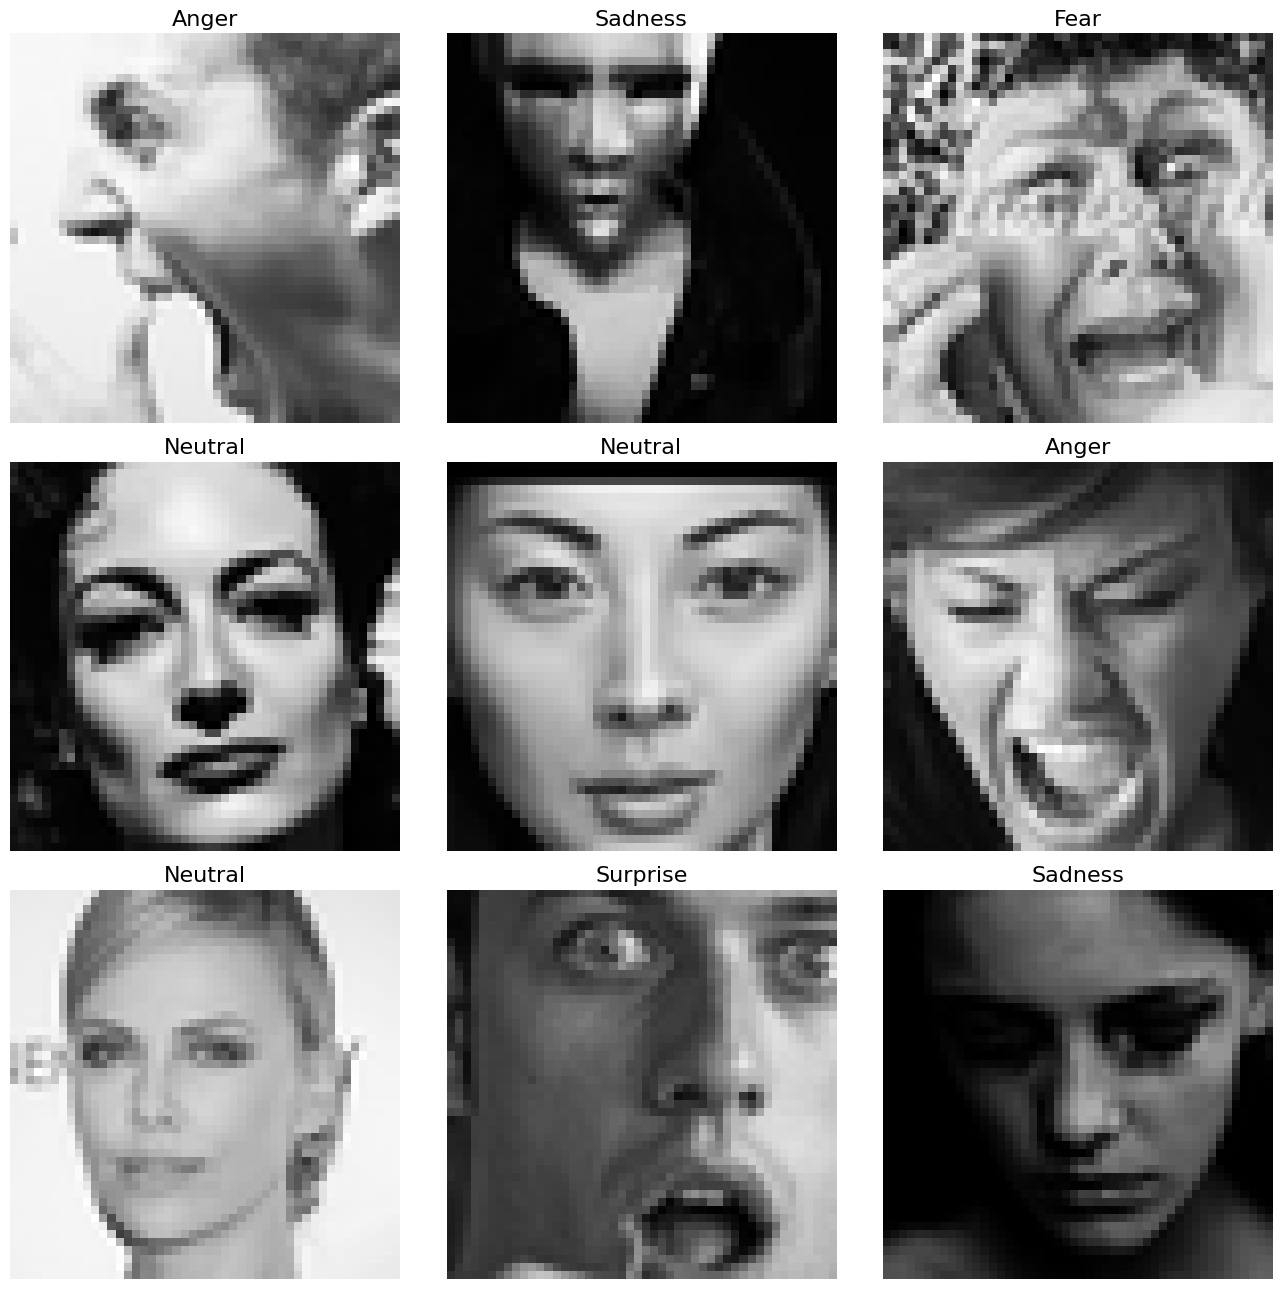

In [ ]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [ ]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()


In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator ,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)


Epoch 1/30
359/359 [==============================] - 139s 206ms/step - loss: 9.9881 - accuracy: 0.2601 - val_loss: 5.5376 - val_accuracy: 0.1683
Epoch 2/30
359/359 [==============================] - 65s 179ms/step - loss: 3.4450 - accuracy: 0.4093 - val_loss: 2.4708 - val_accuracy: 0.3796
Epoch 3/30
359/359 [==============================] - 66s 185ms/step - loss: 1.8466 - accuracy: 0.4609 - val_loss: 1.5715 - val_accuracy: 0.4799
Epoch 4/30
359/359 [==============================] - 64s 179ms/step - loss: 1.4291 - accuracy: 0.5088 - val_loss: 1.3333 - val_accuracy: 0.5165
Epoch 5/30
359/359 [==============================] - 66s 184ms/step - loss: 1.3105 - accuracy: 0.5318 - val_loss: 1.3466 - val_accuracy: 0.5151
Epoch 6/30
359/359 [==============================] - 66s 183ms/step - loss: 1.2363 - accuracy: 0.5592 - val_loss: 1.2385 - val_accuracy: 0.5584
Epoch 7/30
359/359 [==============================] - 67s 187ms/step - loss: 1.1991 - accuracy: 0.5787 - val_loss: 1.2684 - val_a

In [ ]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
359/359 [==============================] - 125s 206ms/step - loss: 1.1541 - accuracy: 0.5923 - val_loss: 1.1540 - val_accuracy: 0.5865
Epoch 2/20
359/359 [==============================] - 68s 188ms/step - loss: 1.1336 - accuracy: 0.5990 - val_loss: 1.1434 - val_accuracy: 0.5914
Epoch 3/20
359/359 [==============================] - 66s 183ms/step - loss: 1.1203 - accuracy: 0.6050 - val_loss: 1.1367 - val_accuracy: 0.5915
Epoch 4/20
359/359 [==============================] - 67s 188ms/step - loss: 1.1138 - accuracy: 0.6055 - val_loss: 1.1313 - val_accuracy: 0.5985
Epoch 5/20
359/359 [==============================] - 65s 181ms/step - loss: 1.1054 - accuracy: 0.6093 - val_loss: 1.1273 - val_accuracy: 0.6006
Epoch 6/20
359/359 [==============================] - 67s 187ms/step - loss: 1.1086 - accuracy: 0.6113 - val_loss: 1.1239 - val_accuracy: 0.6037
Epoch 7/20
359/359 [==============================] - 65s 180ms/step - loss: 1.1055 - accuracy: 0.6101 - val_loss: 1.1226 - val_a

In [ ]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:

model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 7s 39ms/step


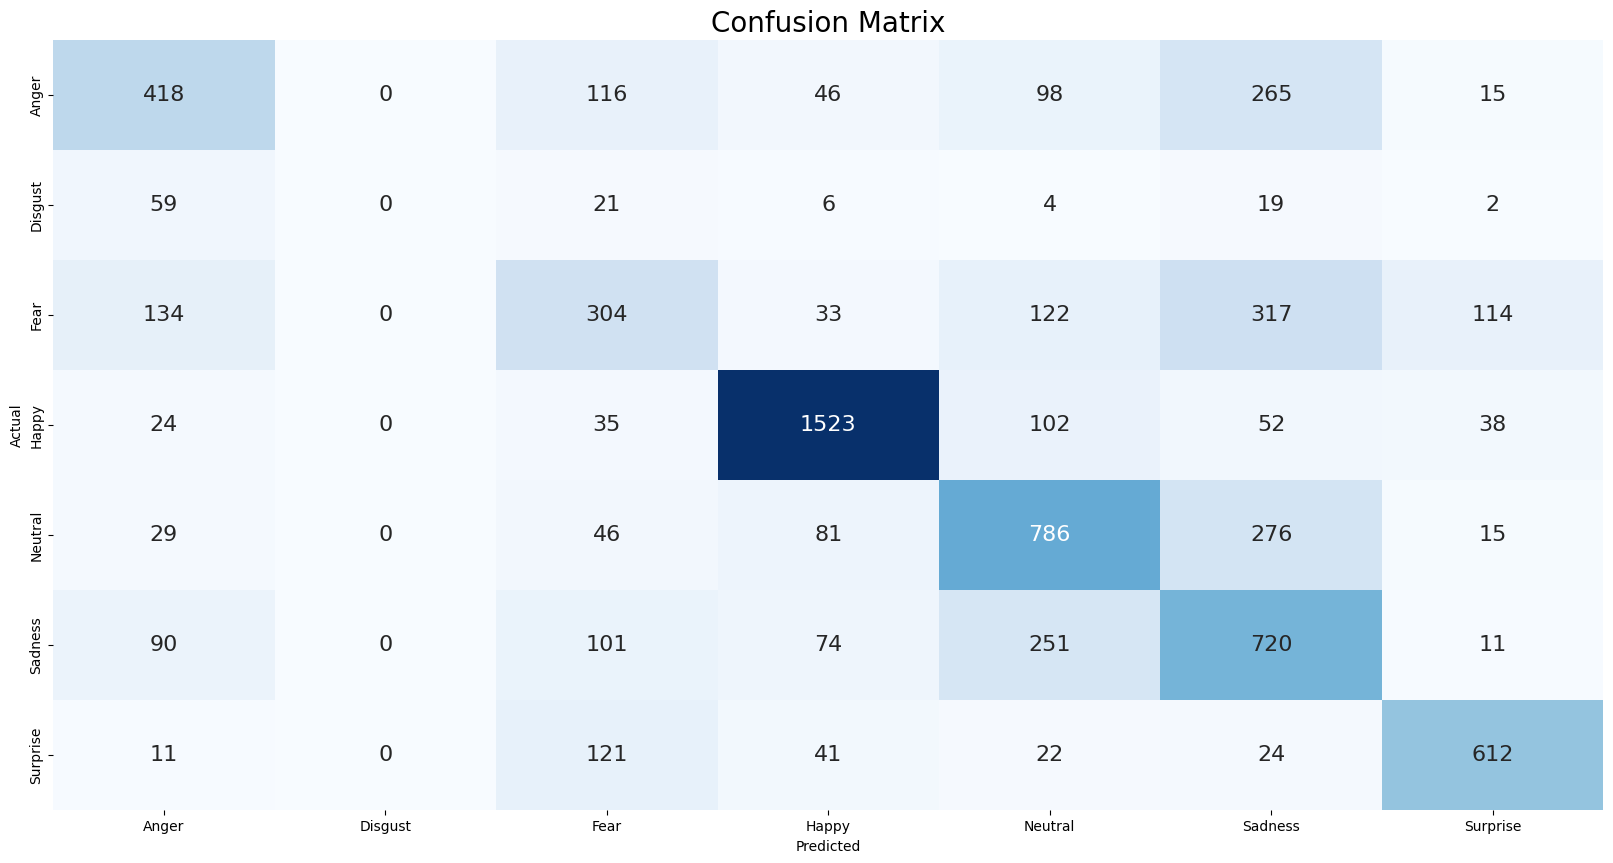

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.55      0.44      0.49       958
           1       0.00      0.00      0.00       111
           2       0.41      0.30      0.34      1024
           3       0.84      0.86      0.85      1774
           4       0.57      0.64      0.60      1233
           5       0.43      0.58      0.49      1247
           6       0.76      0.74      0.75       831

    accuracy                           0.61      7178
   macro avg       0.51      0.51      0.50      7178
weighted avg       0.60      0.61      0.60      7178



In [ ]:
model.save("EmotionRecognitionDenseNet169.h5")

ROC AUC score: 0.9055119631973522


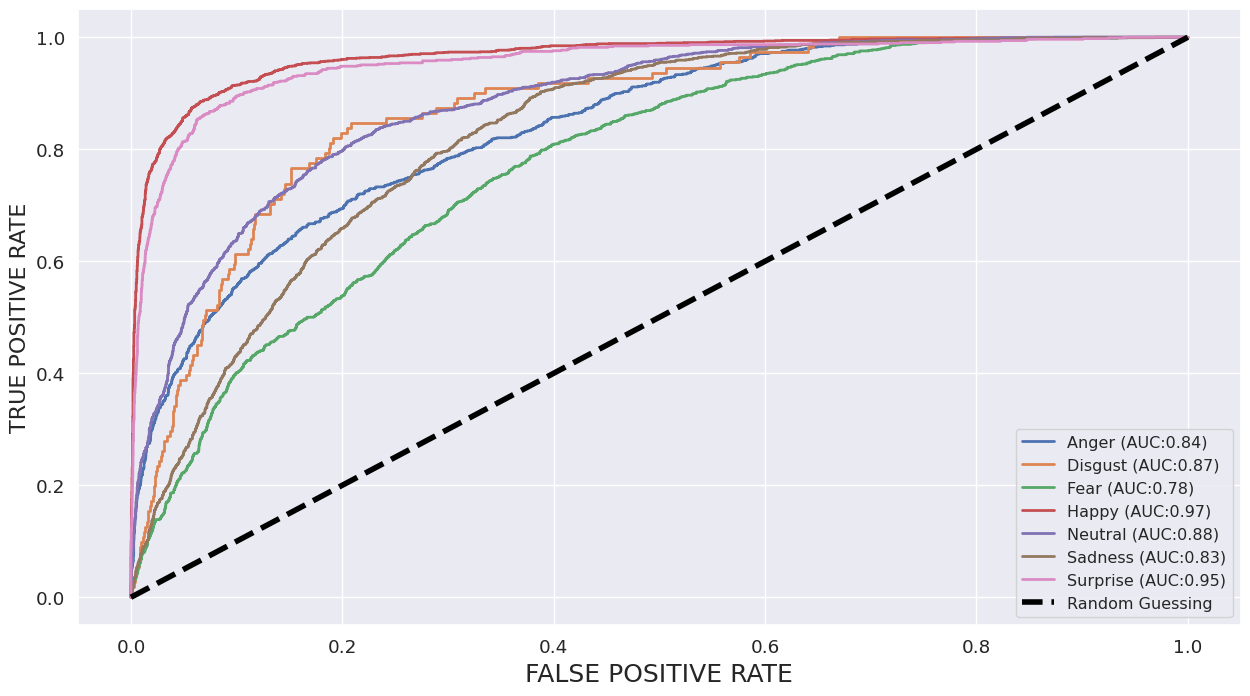

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8738160509288192
